In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Run once
# !pip install -Uqq convertdate pystan==2.19.1.1 prophet

In [4]:
import os
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
import investpy
from datetime import date, datetime
from pathlib import Path
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass, field

In [5]:
%matplotlib inline
pd.set_option('display.max_rows', 500)

In [6]:
COUNTRY = "malaysia"                   
DATASET_FOLDER = "test_data"
TARGET_DATASET_FOLDER = f"{DATASET_FOLDER}/{COUNTRY}"
STOCKS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks.csv"
STOCKS_INFO_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_info.csv"
STOCKS_FINANCE_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_finance.csv"
STOCKS_DIVIDENDS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_dividends.csv"
STOCKS_SELECTED = f"{TARGET_DATASET_FOLDER}/stocks_selected.csv"
STOCKS_HISTORICAL_PRICES = f"{TARGET_DATASET_FOLDER}/stocks_historcal_prices.csv"

FROM_DATE = '1/1/2017'
TO_DATE = datetime.strftime(date.today(), '%d/%m/%Y')

In [13]:
def read_csv(file):
    if not os.path.isfile(file):
        return None
    return pd.read_csv(file)

def save_csv(df, file_name, index=True):
    df.to_csv(file_name, header=True, index=index)

In [16]:
df_stocks_selected = read_csv(STOCKS_SELECTED)

In [20]:
def get_stock_historical_prices(symbol, country):
    try:
        return investpy.get_stock_historical_data(symbol, country, FROM_DATE, TO_DATE)
    except:
        return None
    
def download_historical_prices(df):
    df_history = None
    count = 0
    for _, row in df.iterrows():
            count = count + 1
            print(f"{count}/{len(df)}: {row.Symbol}")
            df_stock = get_stock_historical_prices(row.Symbol, COUNTRY)
            if df_stock is None:
                continue
            df_stock['Symbol'] = row.Symbol
            if df_history is None:
                df_history  = df_stock
            else:
                df_history = df_history.append(df_stock)
            if count % 10 == 0:
                save_csv(df_history, STOCKS_HISTORICAL_PRICES)
                time.sleep(3)
    save_csv(df_history, STOCKS_HISTORICAL_PRICES)

In [21]:
download_historical_prices(df_stocks_selected)

1/31: MBBM
2/31: BSTB
3/31: BMYS
4/31: BATO
5/31: UOAD
6/31: TPGC
7/31: ASTR
8/31: KRIB
9/31: BERA
10/31: DOMN
11/31: EWEI
12/31: HLIB
13/31: INNO
14/31: JAYC
15/31: JHTN
16/31: LHEN
17/31: MATE
18/31: MATR
19/31: NCHB
20/31: PHUA
21/31: OKAC
22/31: SPLH
23/31: PTRE
24/31: PERT
25/31: ELKD
26/31: LTKH
27/31: KIPR
28/31: SERB
29/31: MQRE
30/31: UOAR
31/31: ATRL


## Forecast Changes

In [24]:
df_history = read_csv(STOCKS_HISTORICAL_PRICES)
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34625 entries, 0 to 34624
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      34625 non-null  object 
 1   Open      34625 non-null  float64
 2   High      34625 non-null  float64
 3   Low       34625 non-null  float64
 4   Close     34625 non-null  float64
 5   Volume    34625 non-null  int64  
 6   Currency  34625 non-null  object 
 7   Symbol    34625 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 2.1+ MB


<AxesSubplot:>

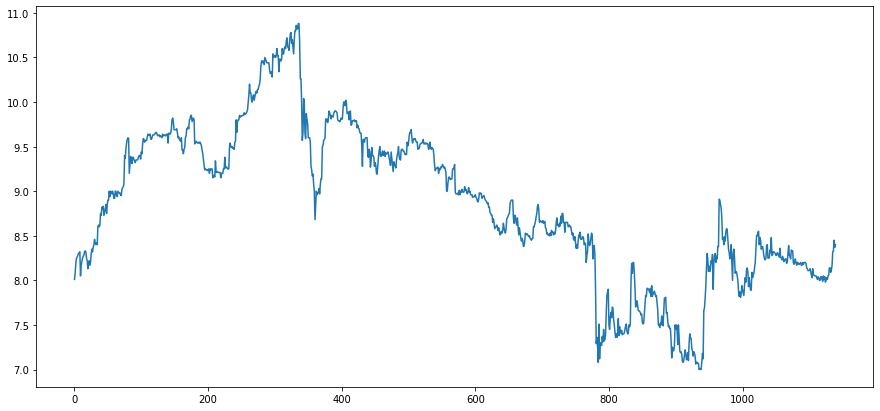

In [43]:
# Try with 1 stock
df_stock = df_history[df_history['Symbol'] == 'MBBM']
df_stock['Close'].plot(figsize = (15,7))

<AxesSubplot:>

0     8.01
1     8.08
2     8.19
3     8.25
4     8.26
5     8.28
6     8.30
7     8.31
8     8.32
9     8.05
10    8.17
11    8.21
12    8.25
13    8.27
14    8.28
15    8.32
16    8.33
17    8.32
18    8.25
19    8.22
20    8.13
21    8.20
22    8.22
23    8.17
24    8.20
25    8.30
26    8.35
27    8.32
28    8.37
29    8.40
Name: Close, dtype: float64

0          NaN
1     0.008739
2     0.013614
3     0.007326
4     0.001212
5     0.002421
6     0.002415
7     0.001205
8     0.001203
9    -0.032452
10    0.014907
11    0.004896
12    0.004872
13    0.002424
14    0.001209
15    0.004831
16    0.001202
17   -0.001200
18   -0.008413
19   -0.003636
20   -0.010949
21    0.008610
22    0.002439
23   -0.006083
24    0.003672
25    0.012195
26    0.006024
27   -0.003593
28    0.006010
29    0.003584
Name: Close, dtype: float64

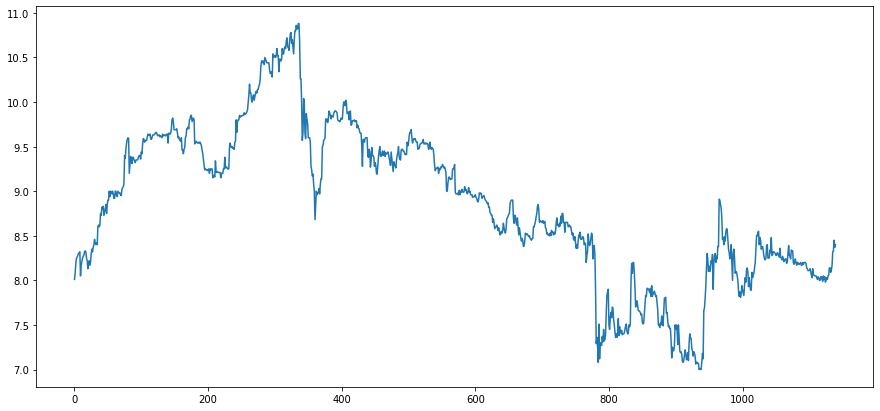

In [45]:
display(df_stock['Close'].head(30))

0     8.01
1     8.08
2     8.19
3     8.25
4     8.26
5     8.28
6     8.30
7     8.31
8     8.32
9     8.05
10    8.17
11    8.21
12    8.25
13    8.27
14    8.28
15    8.32
16    8.33
17    8.32
18    8.25
19    8.22
20    8.13
21    8.20
22    8.22
23    8.17
24    8.20
25    8.30
26    8.35
27    8.32
28    8.37
29    8.40
Name: Close, dtype: float64